In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import set_config 
from sklearn.utils import estimator_html_repr 
from IPython.core.display import display, HTML 

In [2]:
from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray 

import re
import time
import datetime

import numpy as np  
import pandas as pd  

import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
import category_encoders as ce
from catboost import CatBoostRegressor

import multiprocessing


#### globals ####

DEP_VAR = 'SalePrice'
n_threads = multiprocessing.cpu_count()
MAX_OH_CARDINALITY = 10
N_ESTIMATORS = 1000
SEED = 5


#### load data ####

train_df = pd.read_csv('C:/Users/Process Research/Downloads/Springboard Assignments/House Prices Advanced Regression Techniques/train.csv')\
            .set_index('Id')\
            .fillna(np.nan)

# split the dependent variable from the features
y_train = train_df.pop(DEP_VAR)
log_y_train = np.log(y_train)


#### create column transformer ####

select_numeric_features = make_column_selector(dtype_include=np.number)
numeric_pipeline = make_pipeline(SimpleImputer(strategy='median', add_indicator=True))  


def select_oh_features(df):

    oh_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x <= MAX_OH_CARDINALITY]\
        .index\
        .tolist()

    return oh_features


oh_pipeline = make_pipeline(SimpleImputer(strategy='constant'), 
                            OneHotEncoder(handle_unknown='ignore'))

def select_hc_features(df):

    hc_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x > MAX_OH_CARDINALITY]\
        .index\
        .tolist()

    return hc_features

hc_pipeline = make_pipeline(ce.GLMMEncoder())


column_transformer = ColumnTransformer(transformers=\
                                       [('numeric_pipeline',
                                         numeric_pipeline, 
                                         select_numeric_features),\
                                        ('oh_pipeline', 
                                         oh_pipeline, 
                                         select_oh_features),\
                                        ('hc_pipeline', 
                                         hc_pipeline, 
                                         select_hc_features)
                                       ],\
                                       n_jobs=n_threads,
                                       remainder='drop')

#### create pipeline ####

cat = CatBoostRegressor(thread_count=n_threads, n_estimators=N_ESTIMATORS, 
                        random_state=SEED, verbose=False)


pipe = Pipeline(steps=[('column_transformer', column_transformer),\
                       ('variancethreshold', VarianceThreshold(threshold=0.0)),\
                       ('selectpercentile', SelectPercentile(f_regression, percentile=90)),\
                       ('model', cat)])

_ = pipe.fit(train_df, log_y_train)

In [3]:
set_config(display='diagram')
display(HTML(estimator_html_repr(pipe)))

In [4]:
expected_model_version = '1.0'
model_path = '../models/Ames_housing_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


In [5]:
ames_housing = pd.read_csv('C:/Users/Process Research/Downloads/Springboard Assignments/House Prices Advanced Regression Techniques/train.csv')

In [6]:
ames_housing_e = ames_housing.set_index('Id')
ames_housing_e = ames_housing_e.dropna(axis='columns')

In [7]:
ames_housing_nums = ames_housing_e.select_dtypes(['number'])

In [8]:
X = ames_housing_nums
y = ames_housing_nums[['SalePrice']]

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int64
 1   LotArea        1460 non-null   int64
 2   OverallQual    1460 non-null   int64
 3   OverallCond    1460 non-null   int64
 4   YearBuilt      1460 non-null   int64
 5   YearRemodAdd   1460 non-null   int64
 6   BsmtFinSF1     1460 non-null   int64
 7   BsmtFinSF2     1460 non-null   int64
 8   BsmtUnfSF      1460 non-null   int64
 9   TotalBsmtSF    1460 non-null   int64
 10  1stFlrSF       1460 non-null   int64
 11  2ndFlrSF       1460 non-null   int64
 12  LowQualFinSF   1460 non-null   int64
 13  GrLivArea      1460 non-null   int64
 14  BsmtFullBath   1460 non-null   int64
 15  BsmtHalfBath   1460 non-null   int64
 16  FullBath       1460 non-null   int64
 17  HalfBath       1460 non-null   int64
 18  BedroomAbvGr   1460 non-null   int64
 19  Kitche

In [10]:
model.X_columns

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [11]:
len(X), len(y)

(1460, 1460)

In [12]:
model.fit(X, y)

C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=183, random_state=47))])

In [13]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [14]:
cv_results['test_score']

array([-353.72860993, -504.98819148, -893.81821244, -361.70879183,
       -765.36018789])

In [15]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(575.9207987124785, 217.82269635988263)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

Calculate Expected Ames Housing Price From The Model

In [16]:
X_bm = ames_housing_nums
y_bm = ames_housing_nums[['SalePrice']]

In [17]:
bm_pred = model.predict(X_bm)

In [18]:
y_bm = y_bm.values

In [19]:
y_bm

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]], dtype=int64)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_bm_flat = y_bm.reshape(-1,1)
print(np.sqrt(mean_squared_error(y_true=y_bm_flat, y_pred=bm_pred)))
print(r2_score(y_true=y_bm_flat, y_pred=bm_pred))

1643.762080705067
0.9995715800931967


The model performance indicates that it is pretty good, with an R-squared value of 0.97.

Ames Housing In Market Context: Features that came up as important in the modeling (not just our final, random forest model) included:

vertical_drop
Snow Making_ac
total_chairs
fastQuads
Runs
LongestRun_mi
trams
SkiableTerrain_ac

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Ames housing sits in the distribution by marking Ames houses' value with a vertical line using matplotlib's axvline function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [21]:
#Add code to the `plot_compare` function that displays a vertical, dashed line on the histogram to indicate Ames's 
#position in the distribution .     Hint: plt.axvline() plots a vertical line, its position for 'feature1'
#would be `ames_housing['feature1'].values, we'd like a red line, which can be specified with c='r', a dashed linestyle is 
#produced by ls='--', and it's nice to give it a slightly reduced alpha value, such as 0.8.
#Don't forget to give it a useful label (e.g. 'Ames Housing') so it's listed in the legend.
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ames_housing_nums[feat_name]
    else:
        ski_x = ames_housing_nums.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30)
    plt.axvline(x=ames_housing_nums[feat_name].values, c='r', ls='--', alpha=0.8, label='Ames housing')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for houses in market share')
    plt.legend()

Ticket price: Look at where Ames houses sits overall amongst all the houses for price.

<ipython-input-22-185785715d19>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


Feature ranking:
1. feature 33 (0.623812)
2. feature 2 (0.175546)
3. feature 22 (0.073147)
4. feature 13 (0.027398)
5. feature 16 (0.024386)
6. feature 4 (0.018522)
7. feature 23 (0.012748)
8. feature 9 (0.010514)
9. feature 10 (0.007744)
10. feature 5 (0.005872)
11. feature 21 (0.005861)
12. feature 20 (0.003425)
13. feature 11 (0.003139)
14. feature 6 (0.002510)
15. feature 18 (0.000676)
16. feature 17 (0.000674)
17. feature 1 (0.000602)
18. feature 19 (0.000551)
19. feature 25 (0.000491)
20. feature 14 (0.000394)
21. feature 0 (0.000314)
22. feature 28 (0.000238)
23. feature 24 (0.000237)
24. feature 3 (0.000232)
25. feature 32 (0.000202)
26. feature 31 (0.000163)
27. feature 8 (0.000152)
28. feature 15 (0.000150)
29. feature 26 (0.000078)
30. feature 29 (0.000065)
31. feature 7 (0.000053)
32. feature 27 (0.000047)
33. feature 12 (0.000044)
34. feature 30 (0.000012)


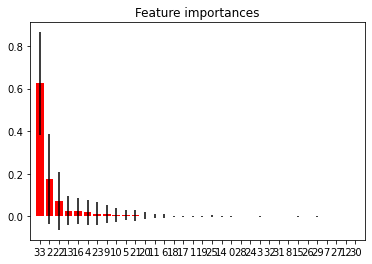

In [22]:
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [23]:
from feature_importance import FeatureImportance
feature_importance = FeatureImportance(pipe)
feature_importance.plot(top_n_features=25)

ModuleNotFoundError: No module named 'feature_importance'